# Modelos Aditivos Generalizados

## Motivación: Problemas recurrentes en modelación

- Nuestro modelo puede concurrir en sobreajuste o subajuste.
- Tenemos herramientas a nuestra disposición para resolver sobreajuste.
- Hasta el momento, no tenemos herramientas a nuestra disposición para resolver subajuste.
- Una forma específica de subajuste es el hecho que nuestras funciones proyectadas pueden que sean no lineales.

### Soluciones a la nolinealidad
- **Lineal**: Ej: Regresión lineal de mínimos cuadrados ordinarios con variables independientes lineales. La forma funcional presenta alto sesgo.
- **Polinomial**: Ej: Regresión lineal de mínimos cuadrados ordinarios con variables independientes polinomiales. La forma funcional presenta alta varianza (reduce capacidad de generalización).
- **GLM**: Modelos lineales generalizados. Ej: Regresión logística. Flexibiliza el proceso de generación de datos, pero sigue siendo lineal.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lec2_graphs as afx

plt.style.use("seaborn")

df = pd.read_csv("kc_house_data.csv")
df["precio_alto"] = np.where(df["price"] > df["price"].mean() + df["price"].std() * 2, 1, 0)

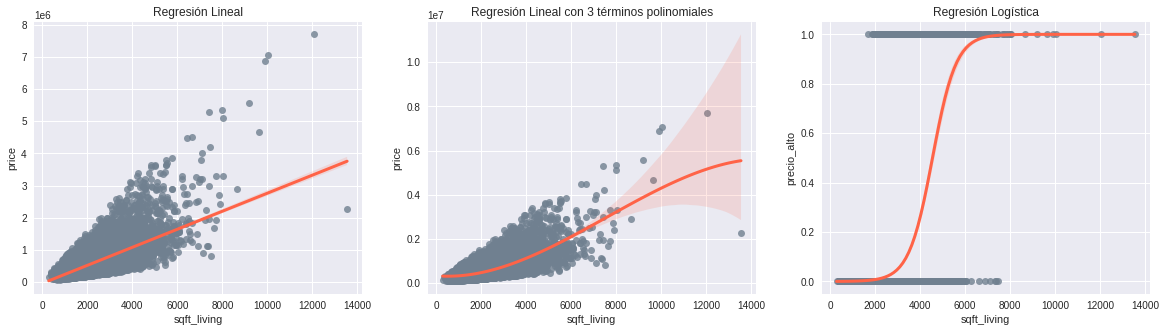

In [2]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.regplot(x="sqft_living", y="price", data=df, scatter_kws = {'color':'slategrey'}, line_kws= {'color': 'tomato', 'linewidth': 3})
plt.title("Regresión Lineal")

plt.subplot(1, 3, 2)
sns.regplot(x="sqft_living", y="price", order=3, data=df, color="palevioletred", scatter_kws = {'color':'slategrey'}, line_kws= {'color': 'tomato', 'linewidth': 3})
plt.title("Regresión Lineal con 3 términos polinomiales")

plt.subplot(1, 3, 3)
sns.regplot(x="sqft_living", y="precio_alto", data=df, logistic=True, color="lightseagreen", scatter_kws = {'color':'slategrey'}, line_kws= {'color': 'tomato', 'linewidth': 3})
plt.title("Regresión Logística");

## Solución propuesta por GAM

- La forma general de GAM busca apoyarse en las fortalezas y debilidades de cada uno de los modelos anteriores.
- Mediante la inclusión la función de vínculo, podemos flexibilizar el comportamiento de nuestro vector objetivo.
- La combinación lineal de parámetros nos asegura cierta estabilidad en la identificación de los resultados.
- La función de identidad específica permite flexibilizar el comportamiento de splines en cada parámetro.
- **Objetivo de GAM**: Estimar las funciones de identidad, y se realiza mediante _backfitting_

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Vamos a utilizar un subconjunto de las columnas para hacer el ejemplo mas expedito
sub = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']]

X_train_pre, X_test_pre, y_train, y_test = train_test_split(sub, df['price'], test_size =.3, random_state = 63)

# Ajustamos el estandarizador sobre el conjunto de entrenamiento (para que aprenda la media y desv. est.)
scaler = StandardScaler().fit(X_train_pre)

# Con el estandarizador ajustado sobre entrenamiento, transformamos el conjunto de entrenamiento con esta estandarizacion
X_train = pd.DataFrame(scaler.transform(X_train_pre), columns = X_train_pre.columns)

# Transformamos el conjunto de pruebas con el estandarizador ajustado sobre entrenamiento
X_test = pd.DataFrame(scaler.transform(X_test_pre), columns = X_test_pre.columns)

In [5]:
from pygam import LinearGAM, s

# definimos el rango de hiperparametros a evaluar
lams = np.logspace(-3, 3, 3)

# Necesitamos generar copias de esta lista de valores a evaluar para cada funcion f(X), que en nuestro caso serán splines
lams = [lams]* len(X_train.columns)

# Definimos el modelo indicandole qué tipo de función debe tratar de ajustar a cada atributo/variable independiente en la matriz que le entregaremos: 
#     s(0) significa que se debe ajustar un término de tipo spline a la primera columna entregada
gam = LinearGAM(s(0) + s(1) + s(2)+ s(3), fit_intercept=True)
#sin_grid_search = gam.fit(X_train.to_numpy(), y_train.to_numpy())

# Realizamos el proceso de búsqueda por gridsearch invocando al método del mismo nombre
search_params = {'lam': lams}
gam.gridsearch(X_train.to_numpy(), y_train.to_numpy(), **search_params)

# Con el método summary obtenemos una tabla con los resultados del ajuste del modelo para la mejor combinación de hiper parámetros
gam.summary()

100% (81 of 81) |########################| Elapsed Time: 0:00:38 Time:  0:00:38


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     50.5084
Link Function:                     IdentityLink Log Likelihood:                               -388710.4607
Number of Samples:                        15129 AIC:                                           777523.9383
                                                AICc:                                           777524.297
                                                GCV:                                      57794407073.9769
                                                Scale:                                    57447204678.7826
                                                Pseudo R-Squared:                                   0.5944
Feature Function                  Lam

In [7]:
gam.lam

[[1000.0], [0.001], [0.001], [0.001]]

- Podemos ver que para todos los atributos el p-value obtenido es considerablemente pequeño por lo que no tendremos que preocuparnos por descartarlos en este caso.
- Para todos los casos se utilizan 20 splines de orden 3.
- Podemos observar que la penalización sobre la concavidad encontrada para la primera columna (`bedrooms`, representada en el término `s(0)`) es considerablemente mayor a la encontrada para las demás columnas, siendo esta $\lambda_{\text{bedrooms}}=1000$.

In [9]:
from sklearn.metrics import mean_squared_error

# Evaluamos desempeño
print('Test RMSE: {0}'.format(np.sqrt(mean_squared_error(y_test, gam.predict(X_test))).round(3)))

Test RMSE: 243684.196


In [10]:
df["price"].describe().round(2)

count      21613.00
mean      540088.14
std       367127.20
min        75000.00
25%       321950.00
50%       450000.00
75%       645000.00
max      7700000.00
Name: price, dtype: float64

- _Revisar lectura 7 para revisar métrica median_absolute_error y su interpretación_

## Dependencias parciales
- Hasta el momento sabemos que los modelos aditivos generalizados permiten incorporar formas funcionales flexibles para generar un buen ajuste a los datos.
- Lamentablemente, las funciones de identidad en el modelo no se pueden interpretar de manera directa. Para ello,:
    - Implementaremos _métodos de dependencia parcial_, que buscan identificar la naturaleza de la dependencia de una función de identidad arbitraria $f(x)$ en los valores conjuntos.
    - Podemos estudiar el comportamiento y respuesta de la predicción con respecto a cada atributo por separado si mantenemos los demás atributos fijos como su media.
    - Graficamos la esperanza de los valores predichos a lo largo de un atributo específico.

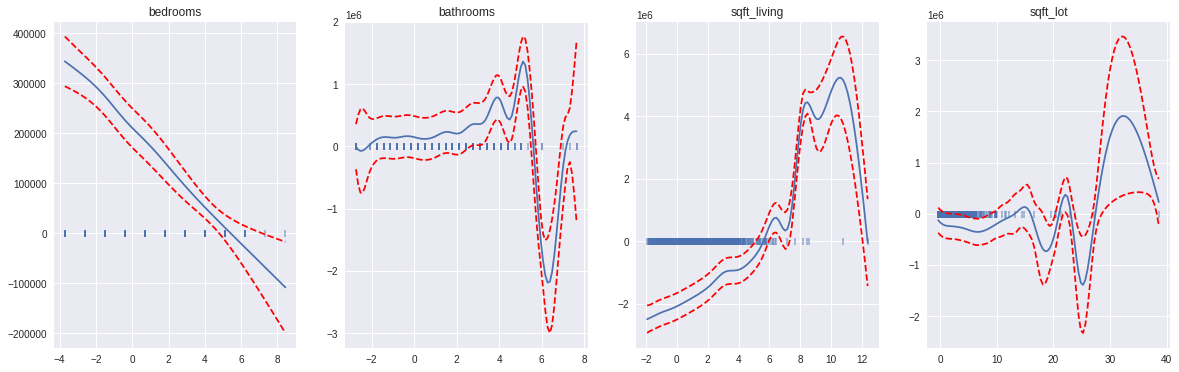

In [11]:
fig, axs = plt.subplots(1,4, figsize = (20,6));
titles = X_train.columns
for i, ax in enumerate(axs.flatten()):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.scatter(X_train[titles[i]], [0] * len(X_train[titles[i]]), marker = '|', alpha = .5)
    ax.set_title(titles[i]);

- La curva parece tener un ajuste más errático donde hay menor cantidad de puntos, es razonable pensar que en un espacio con poca cantidad de información las splines tendrán una mayor varianza.